# Pairwise LD for functional SNPs

This notebook computes and plots pairwise LD between interesting functional SNPs.

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline

In [2]:
# load in selected missense variants
tbl_variants_selected = etl.frompickle('../data/tbl_variants_missense_selected.pkl')
tbl_variants_selected.nrows()

23

In [3]:
# load in haplotypes
callset_haps = np.load('../data/haps_phase1.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
pos.shape, haps.shape

((341998,), (341998, 1530))

In [4]:
def lewontin_d_prime(h, i, j, a=1, b=1):
    """Compute LD between a pair of alleles.
    
    Parameters
    ----------
    h : array
        Haplotype array.
    i : int
        First variant index.
    j : int
        Second variant index.
    a : int
        First variant allele.
    b : int
        Second variant allele.
    
    Returns
    -------
    ld : float
    
    """
    
    # setup
    h = allel.HaplotypeArray(h)
    n_a = n_b = 0  # allele counts
    n_ab = 0  # haplotype counts
    n = 0  # allele number (i.e., number of calls)
    
    # iterate over haplotypes, counting alleles and haplotypes
    for k in range(h.n_haplotypes):
        
        # access alleles
        allele_ik = h[i, k]
        allele_jk = h[j, k]
        
        # only count if allele non-missing at both sites
        if allele_ik < 0 or allele_jk < 0:
            continue
            
        # accumulate
        if allele_ik == a:
            n_a += 1
        if allele_jk == b:
            n_b += 1
        if allele_ik == a and allele_jk == b:
            n_ab += 1
        n += 1
        
#     log('D_prime counts:', 'i', i, 'j', j, 'a', a, 'b', b, 'n', n, 'n_a', n_a, 'n_b', n_b)
        
    # bail out if no data or either allele is absent or fixed
    if n == 0 or n_a == 0 or n_b == 0 or n == n_a or n == n_b:
        return None
    
    # N.B., compute D prime using counts rather than frequencies to avoid floating-point errors
    # N.B., preserve the sign of D prime to retain information about linkage versus repulsion
    
    # compute coefficient of linkage disequilibrium * n**2
    D_ab = (n * n_ab) - (n_a * n_b)
    
    # compute normalisation coefficient * n**2
    if D_ab >= 0:
        D_max = min(n_a * (n - n_b), (n - n_a) * n_b)
    else:
        D_max = min(n_a * n_b, (n - n_a) * (n - n_b))

    # compute D prime
    D_prime = D_ab / D_max
    
#     log('D_prime', D_prime, i, j, a, b, n, n_a, n_b, D_ab, D_max)
#     if np.isnan(D_prime):
#         log('nan')
#        log(D_prime, i, j, a, b, n, n_a, n_b, D_ab, D_max)
        
    return D_prime


In [5]:
pos_selected = allel.SortedIndex(sorted(tbl_variants_selected.values('POS').set()))
pos_selected

0,1,2,3,4,...,16,17,18,19,20
2390177,2391228,2399997,2400071,2416980,...,2430880,2430881,2431019,2431061,2431079


In [6]:
tbl_variants_selected

0|CHROM,1|POS,2|num_alleles,3|REF,4|ALT,5|AC,6|ALTIX,7|FILTER_PASS,8|NoCoverage,9|LowCoverage,10|HighCoverage,11|LowMQ,12|HighMQ0,13|RepeatDUST,14|RepeatMasker,15|RepeatTRF,16|FS,17|HRun,18|QD,19|ReadPosRankSum,20|SNPEFF_Allele,21|SNPEFF_Annotation,22|SNPEFF_HGVS_c,23|SNPEFF_HGVS_p,24|SNPEFF_Feature_ID,25|AF_AOM,26|AF_BFM,27|AF_GWA,28|AF_GNS,29|AF_BFS,30|AF_CMS,31|AF_GAS,32|AF_UGS,33|AF_KES,34|check_allele,35|exon_start,36|exon_end,37|exon,38|AGAP004707-RA,39|AGAP004707-RB,40|AGAP004707-RC,41|Davies-C1N2,42|Davies-C3N2,43|Davies-C5N2,44|Davies-C7N2,45|Davies-C8N2,46|Davies-C10N2,47|Davies-C11N2,48|Davies-C1N9,49|Davies-C8N9,50|Davies-C1N9ck,51|haps_vidx,52|dprime_L995S,53|dprime_L995F
2L,2390177,2,G,A,198,0,True,0,3,8,0,0,False,False,False,0.12695,1,18.625,0.83496,A,missense_variant,n.761G>A,p.Arg254Lys,AGAP004707-RA,0.0,0.0,0.0,0.0,0.0,0.316363636364,0.214285714286,0.0,0.0,True,2390129,2390341,7,R254K,R254K,R254K,R260K,R217K,R260K,R260K,R271K,R260K,R260K,R260K,R271K,R260K,817,-0.9640591966173362,0.9181216134858519
2L,2391228,3,G,C,10,0,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,C,missense_variant,n.1204G>C,p.Val402Leu,AGAP004707-RA,0.0,0.0724637681159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L,838,-1.0,-0.8025806451612904
2L,2391228,3,G,T,9,1,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,None,None,None,None,None,0.0,0.0652173913043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L,838,-1.0,-1.0
2L,2399997,2,G,C,38,0,True,0,1,7,0,0,False,False,False,13.359,0,15.688,0.11798,C,missense_variant,n.1396G>C,p.Asp466His,AGAP004707-RA,0.0,0.0,0.0,0.0,0.0,0.0690909090909,0.0,0.0,0.0,True,2399898,2400173,11i+,D466H,D466H,D466H,D472H,D429H,D417H,D472H,D483H,D472H,D472H,D472H,D483H,D472H,1080,-1.0,1.0
2L,2400071,3,G,A,16,0,True,0,0,8,0,0,False,False,False,5.6875,0,16.969,1.3232,A,missense_variant,n.1470G>A,p.Met490Ile,AGAP004707-RA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818181818,True,2399898,2400173,11i+,M490I,M490I,M490I,M496I,M453I,M441I,M496I,M507I,M496I,M496I,M496I,M507I,M496I,1083,-1.0,-1.0


In [7]:
pos_selected.shape

(21,)

In [8]:
loc_selected = pos.locate_keys(pos_selected)
np.count_nonzero(loc_selected)

21

In [9]:
haps_selected = haps[loc_selected]
haps_selected

<HaplotypeArray shape=(21, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 2 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 1 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [10]:
ac = haps_selected.count_alleles()
ac.displayall()

,0,1,2
0,1332,198,0
1,1511,10,9
2,1492,38,0
3,1512,16,2
4,1498,32,0
5,1100,430,0
6,755,775,0
7,1519,11,0
8,1525,5,0
9,1511,19,0


## Compute and plot pairwise LD

In [11]:
def compute_ld():
    global ld
    recs = list(tbl_variants_selected.records())
    n = len(recs)
    ld = np.zeros((n, n), dtype='f8')
    for i in range(n):
        i_pos = recs[i].POS
        i_allele = recs[i].ALTIX + 1
        i_vidx = pos_selected.locate_key(i_pos)
        log('row', i, i_vidx, i_pos, i_allele)
        for j in range(i+1, n):
            j_pos = recs[j].POS
            j_allele = recs[j].ALTIX + 1
            j_vidx = pos_selected.locate_key(j_pos)
    #         log('col', j, j_vidx, j_pos, j_allele)
            v = lewontin_d_prime(haps_selected, i_vidx, j_vidx, i_allele, j_allele)
    #         log('D_prime', v)
            ld[i, j] = v
            ld[j, i] = v
        
    
compute_ld()

row 0 0 2390177 1
row 1 1 2391228 1
row 2 1 2391228 2
row 3 2 2399997 1
row 4 3 2400071 1
row 5 3 2400071 2
row 6 4 2416980 1
row 7 5 2422651 1
row 8 6 2422652 1
row 9 7 2424384 1
row 10 8 2425077 1
row 11 9 2429617 1
row 12 10 2429745 1
row 13 11 2429897 1
row 14 12 2429915 1
row 15 13 2430424 1
row 16 14 2430817 1
row 17 15 2430863 1
row 18 16 2430880 1
row 19 17 2430881 1
row 20 18 2431019 1
row 21 19 2431061 1
row 22 20 2431079 1


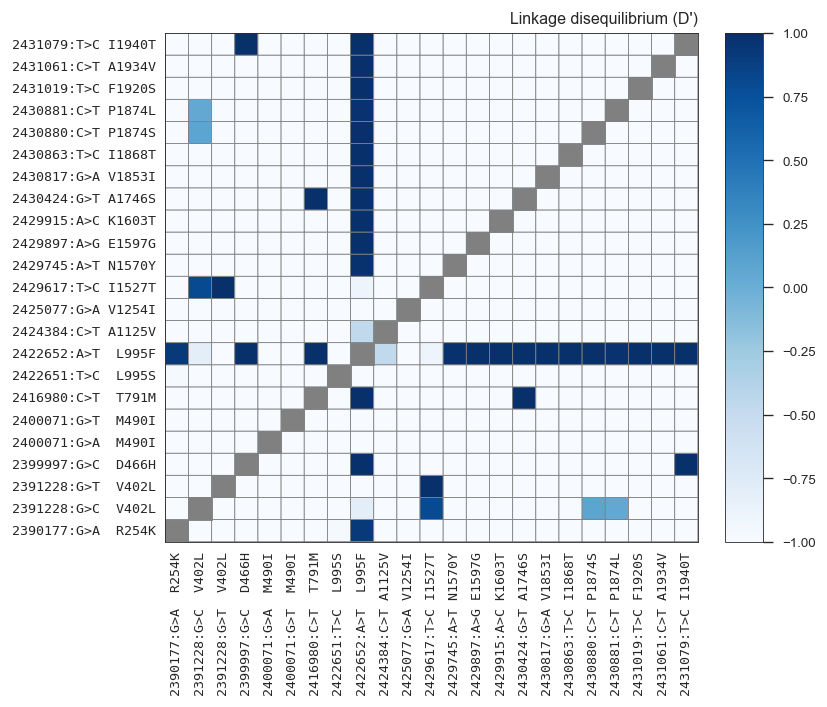

In [12]:
def fig_pw_ld():

    fig = plt.figure(figsize=(7, 6), dpi=120)

    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[7, .5])

    # sns.despine(ax=ax, offset=5)
    #sns.heatmap(ld, vmin=-1, vmax=1, center=0, square=True, ax=ax, cmap='Blues', cbar_kws=dict(ticks=[-1, -.5, 0, .5, 1]))

    ax = fig.add_subplot(gs[0])
    im = ax.pcolormesh(ld, vmin=-1, vmax=1, cmap='Blues', shading='flat', edgecolors='gray', linewidths=.5, antialiased=True)

    labels = ['%s:%s>%s %s' % (rec.POS, rec.REF, rec.ALT, rec['AGAP004707-RA'].rjust(6))
              for rec in tbl_variants_selected.records()]
    # ax.invert_yaxis()
    ticks = np.arange(ld.shape[0]) + .5
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels, rotation=90, ha='center', va='top', fontdict=dict(family='monospace'))
    ax.set_yticklabels(labels, rotation=0, va='center', ha='right', fontdict=dict(family='monospace'));
    ax.set_xlim(0, ld.shape[0])
    ax.set_ylim(0, ld.shape[0])
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    for i in range(ld.shape[0] + 1):
        ax.add_patch(plt.Rectangle((i-1, i-1), 1, 1, color='gray'))
    ax.set_title("Linkage disequilibrium (D')", loc='right')

    cax = fig.add_subplot(gs[1])
    fig.colorbar(im, cax=cax)

    fig.tight_layout()
    fig.savefig('../artwork/fig_ld.png', dpi=300, bbox_inches='tight')
    

fig_pw_ld()